### $$ Analyste :\;\;\;\;\;\;\;\;\;\;\; Lionel \;PETIOTE$$

# Project Title

### $$ Box \;Office\; Insights: What\; Makes\; a\; Movie\; Successful? $$

## Overview

Ce projet consiste à accompagner une entreprise dans le lancement de son propre studio de production cinématographique. Inspirée par le succès des grandes plateformes comme Netflix, Amazon ou Disney, l’entreprise souhaite produire des films originaux, mais ne dispose d’aucune expertise préalable dans l’industrie du cinéma.

Pour se faire, nous disposons de données regroupant des informations détaillées sur des milliers de films. Le but est d’explorer ces données afin d’identifier les caractéristiques des films qui réussissent le mieux, notamment en termes de popularité et de réception critique et d’en tirer des recommandations concrètes sur les types de films à privilégier.

## Business Understanding

Dans le cadre de ce projet, l’objectif principal est de comprendre les facteurs qui influencent le succès commercial d’un film, en se basant sur des données historiques telles que le budget, le genre, la durée, les revenus au box-office, les scores critiques, etc. Cette compréhension permettra d’identifier les variables les plus déterminantes pour la rentabilité ou la popularité d’un film, afin de guider les décisions stratégiques des producteurs, distributeurs ou investisseurs du secteur cinématographique. En posant les bonnes questions dès le départ, comme "Quels types de films rapportent le plus de bénéfices ?", ou "Le budget est-il réellement un bon indicateur du succès ?" Cette étape de compréhension métier vise à transformer un problème commercial complexe en un problème analytique clair et exploitable.

## Importation

In [1]:
# Imports biblioteques here
import itertools
import numpy as np
import pandas as pd
from numbers import Number
import sqlite3
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import pickle

In [2]:
# Imports Data
# Create connections
path = 'Data/im.db'
conn = sqlite3.connect(path)
cursor = conn.cursor()

df1 = pd.read_csv('Data/tmdb.movies.csv')

df2 = pd.read_csv('Data/bom.movie_gross.csv')

df3 = pd.read_csv('Data/tn.movie_budgets.csv')

df4 = pd.read_csv('Data/rt.reviews.tsv', sep='\t', encoding='latin1')

df5 = pd.read_csv('Data/rt.movie_info.tsv', sep='\t')

## Data Understanding

Les données utilisées dans ce projet proviennent de plusieurs sources hétérogènes, notamment une base de données relationnelle structurée en plusieurs tables, ainsi que des fichiers au format CSV et TSV. Cette diversité nécessite une phase d’exploration approfondie afin de bien comprendre le contenu, la structure, la qualité et la cohérence des données disponibles. L’objectif est d’identifier les principales variables d’intérêt et de comprendre les relations entre les différentes tables et fichiers. Cette étape est cruciale pour établir une vue d’ensemble cohérente du jeu de données et orienter efficacement les phases ultérieures de préparation et d’analyse.

In [3]:
# Faisons ressortir les différentes tables de la base de données

table_name_query = """SELECT name AS 'Table Names' 
    FROM sqlite_master 
    WHERE type='table';"""

pd.read_sql(table_name_query, conn)

,Table Names
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers
8,movies_clean
9,movie_clean


### ERD of the Database

Les tables d'une base de données relationnelle sont inter-reliées entre elles par différents types de liaison $(1:1,  1:n,  n:1,  n:n)$. La compréhension des relations qui existent entre les différentes tables se fait via le schéma relationnel de la table (ERD mis pour Entity-Relationship Diagram).

Voici le schéma relationnel de notre base de données :

<img src="images/IMDB_ERD.jpeg">

###### Commentaires

En suivant les jeux $clés \;primaires - clés \;étrangères$, on parvient à déceller les différentes relations qui existent entre les tables dans la base de données im.bd.

### Autres sources de données

Dans les cellules qui suivent, on fait ressortir un aperçu pour chaque autre source de données en affichant leurs 5 premiers enregistrements ainsi que leur dimension.

In [4]:
df1.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [5]:
df1.shape

(26517, 10)

In [6]:
df2.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [7]:
df2.shape

(3387, 5)

In [8]:
df3.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [9]:
df3.shape

(5782, 6)

In [10]:
df4.head()

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"


In [11]:
df4.shape

(54432, 8)

In [12]:
df5.head(50)

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN
5,8,The year is 1942. As the Allies unite overseas...,PG,Drama|Kids and Family,Jay Russell,Gail Gilchriest,"Mar 3, 2000","Jul 11, 2000",NaN,NaN,95 minutes,Warner Bros. Pictures
6,10,Some cast and crew from NBC's highly acclaimed...,PG-13,Comedy,Jake Kasdan,Mike White,"Jan 11, 2002","Jun 18, 2002",$,"41,032,915",82 minutes,Paramount Pictures
7,13,"Stewart Kane, an Irishman living in the Austra...",R,Drama,Ray Lawrence,Raymond Carver|Beatrix Christian,"Apr 27, 2006","Oct 2, 2007",$,"224,114",123 minutes,Sony Pictures Classics
8,14,"""Love Ranch"" is a bittersweet love story that ...",R,Drama,Taylor Hackford,Mark Jacobson,"Jun 30, 2010","Nov 9, 2010",$,"134,904",117 minutes,NaN
9,15,When a diamond expedition in the Congo is lost...,PG-13,Action and Adventure|Mystery and Suspense|Scie...,Frank Marshall,John Patrick Shanley,"Jun 9, 1995","Jul 27, 1999",NaN,NaN,108 minutes,NaN


In [13]:
df5.shape

(1560, 12)

### Commentaires
Après avoir analysé la structure des différentes sources de données, il apparaît que la fusion des tables ou fichiers n’est ni intuitive ni véritablement pertinente. Les relations entre certaines sources sont faibles, imprécises ou absentes, ce qui rendrait toute tentative de fusion difficilement interprétable et peu fiable.

De ce fait, j'ai fait le choix de travailler avec chaque source de manière indépendante, en tenant compte de leur richesse informationnelle respective. L’analyse priorisera les bases de données disposant de la plus grande quantité de données exploitables, tout en explorant les possibilités de recoupement ou de validation croisée des résultats entre les sources. Cette approche permettra d’assurer la cohérence des analyses tout en respectant les limites structurelles des données disponibles.

## $$ 1 - La \;base\; de\; données\; IMBD $$

L'ERD de la bse nous renseigne sur les différentes tables qui la composent et sur l'ensembles des informations que renferme chaque table via les noms des colonnes. En penchant sur le schéma structurel et sur l'essence des données, on arrive à repérer la table principale de la base qui correspond à la table $movie\_basics$.

Explorons de plus près l'agencement des données à l'intérieur de cette table.

In [14]:
# Apperçu sur la table movie_basics
movie_basics = """SELECT *
    FROM movie_basics;"""

table_movie_basics = pd.read_sql(movie_basics, conn) # Stockage de la table dans un DataFrame
pd.read_sql(movie_basics, conn)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
...,...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy
146142,tt9916730,6 Gunn,6 Gunn,2017,116.0,None


#### Commentaire

La table movie_basics comporte 146 144 lignes (enregistrements) et 6 colonnes. Elle dispose d'une $clé\; primaire$ nommée movie_id qui est censée unique et qui caractérise chaque enregistrement de la table.

Vérifions qu'il n'y a pas de doublure dans la colonne movie_id de la table movie_basisc.

In [15]:
# Réperer les doublons dans la table 
doublure = """SELECT movie_id, COUNT(*) AS doublons
FROM movie_basics
GROUP BY movie_id
HAVING COUNT(*) > 1
ORDER BY doublons DESC;"""

pd.read_sql(doublure, conn)

,movie_id,doublons


#### Commentaire

Super!

Les 146 144 lignes de la table movie_basics représentent chacune un film particulier, il n'y a pas de ligne répétée dans cette table.

In [16]:
# Analyse de la complétude des données de la table movie_basics
valeurs_manquantes = table_movie_basics.isnull().mean() * 100
valeurs_manquantes = valeurs_manquantes.sort_values(ascending=True)
valeurs_manquantes

movie_id            0.000000
primary_title       0.000000
start_year          0.000000
original_title      0.014369
genres              3.700460
runtime_minutes    21.717621
dtype: float64

#### Commentaire

La colonne genre comporte 3.70 % de valeurs manquantes. Comme l'un des objectifs clés des analyses est de déterminer quels genres, quelles catégories de films que les gens comsomment/apprécient le plus, donc la colonne $genre$ est d'une importance particulière.

De ce fait, je me permets de supprimer les enregistrements ne disposant pas d'information sur le genre. ($à\; faire\; dans\; Data\; Preparation$).

## Data Preparation

### Recherche de valeurs abbérantes

In [17]:
# Rating minimale
pd.read_sql("SELECT MIN(averagerating) FROM movie_ratings" ,conn)

,MIN(averagerating)
0,1.0


In [18]:
# Rating maximale
pd.read_sql("SELECT MAX(averagerating) FROM movie_ratings" ,conn)

,MAX(averagerating)
0,10.0


In [19]:
# Durée minimale
pd.read_sql("SELECT MIN(runtime_minutes) FROM movie_basics" ,conn)

,MIN(runtime_minutes)
0,1.0


In [20]:
# Durée maximale
pd.read_sql("SELECT MAX(runtime_minutes) FROM movie_basics" ,conn)

,MAX(runtime_minutes)
0,51420.0


La colonne runtime_minutes semble avoir des valeurs abbérantes (Un documentaire de 51 420 minutes, ce qui correspond à un peu plus de 35 jours), je vais filtrer ces valeurs qui semblent pas trop logiques pour garder que les films de 300 minutes au max (5h, largement suffisant pour un film).

### Création de view

##### Créons une vue sur la base de données en etrayant uniquement les colonnes les plus pertinentes pour notre analyse et supprimant les enregistrememts ayant des valeurs manquantes essentielles (genres, averagerating ou numvotes).

In [21]:
jointure = """ CREATE VIEW IF NOT EXISTS imbd_cleaned AS
SELECT
    mb.movie_id,
    mb.primary_title,
    mb.original_title,
    mb.start_year,
    mb.runtime_minutes,
    mb.genres,
    mr.averagerating,
    mr.numvotes,
    d.person_id,
    GROUP_CONCAT(DISTINCT ma.title) AS alt_titles
FROM movie_basics AS mb
LEFT JOIN movie_ratings AS mr ON mb.movie_id = mr.movie_id
LEFT JOIN directors AS d ON mb.movie_id = d.movie_id
LEFT JOIN movie_akas AS ma ON mb.movie_id = ma.movie_id AND ma.is_original_title = 1
WHERE mb.genres IS NOT NULL
    AND mr.averagerating IS NOT NULL
    AND mr.numvotes IS NOT NULL
    AND mb.runtime_minutes <= 300
GROUP BY mb.movie_id;
"""

cursor.execute(jointure)

In [22]:
Base_DataFrame = pd.read_sql("""SELECT * FROM imbd_cleaned;""", conn)

## Analysis and Results

### Dégagement de compréhension

En regardant la structure des données de la base à la lumière des objectifs de l'analyse, l'une des premières reflèxes serait de selectionner les films avec les  $AVERAGERATING$ les plus élevés, qui correspondraient aux films les plus aimés du public. 

Dans cette logique d'idée, faisons ressortir les 100 films les mieux notés? (les films les plus satisfaisants suivant leur score)

In [23]:
best_classement = """SELECT movie_id, genres, averagerating, numvotes
    FROM imbd_cleaned
 ORDER BY averagerating DESC
 LIMIT 100;"""

pd.read_sql(best_classement, conn)

,movie_id,genres,averagerating,numvotes
0,tt10176328,Documentary,10.0,5
1,tt10378660,"Comedy,Drama",10.0,5
2,tt1770682,"Crime,Documentary",10.0,5
3,tt2632430,Documentary,10.0,5
4,tt4109192,Documentary,10.0,6
...,...,...,...,...
95,tt1918892,Documentary,9.4,30
96,tt2076269,Documentary,9.4,5
97,tt2123262,Documentary,9.4,9
98,tt2154054,"Documentary,Drama",9.4,5


#### Le nombre de personnes ayant donné leur avis sur un film ne joue-t-il pas dans la note moyenne que va avoir ce film?

In [24]:
# Calculons le nombre de votes moyen pour les 100 genres de films les mieux notés
mean = """SELECT AVG(numvotes) AS mean_top_100
FROM (
    SELECT *
    FROM imbd_cleaned
 ORDER BY averagerating DESC
 LIMIT 100
) AS top_100;"""

pd.read_sql(mean, conn)

,mean_top_100
0,235.31


Le nombre moyen de votes pour les 100 films les mieux notés est de 235.31

##### Commentaires

On constate que les 100 films les mieux notés ont des scores allant de 9.4 jusqu'à 10/10. Cependant, ces de films ont un nombre d'avis relativement petits : 235.31 votes en moyenne (la grande majorité n'a que 5 utilisateurs qui les notent).

In [25]:
# Calculons le nombre moyen de votes global sur la base de données
mean ="""SELECT AVG(numvotes) AS moyenne
FROM imbd_cleaned;"""

pd.read_sql(mean, conn)

,moyenne
0,3955.838497


Le nombre moyen de votes pour les films les mieux notés est de 3955.838497

#### Conclusion
##### Les de films les mieux notés ne sont pas forcément les meilleurs films, surtout s'ils reçoivent  un nombre de votes très faibles par rapport aux autres. Par exemple, les 100  films les mieux notés ont en moyenne 235.31 voix. Comparé au nombre moyen de votes total qui est de 3 955.83, leur taux de vote est très peu représentatif.

#### Résolution

###### On comprend rapidedent qu'on peut se baser sur la note moyenne simple pour dire que le public apprécie tel ou tel genre de films.
###### Il convient donc de calculer un score pondéré tenant compte de la note moyenne du genre et du nombre de votes.


## Formule du score pondéré IMDb

Le score pondéré \( W \) est calculé à l'aide de la formule suivante :


$$ W = \frac{v}{v + m} \cdot R + \frac{m}{v + m} \cdot C $$


où :

- $ R $ = note moyenne du film  
- $ v $ = nombre de votes pour le film  
- $ m $ = nombre minimum de votes requis pour être listé  
- $ C $ = note moyenne de tous les films dans la base de données


##### Déterminons le nombre de votes minimal de validation
Le nombre de votes par film n'est pas du tout homogène, certains films sont notés par moins de 10 utilisateurs (min numvotes = 5) alors que d'autres sont notés par plus d'un million d'utilisateurs (max numvotes = 1 841 066).
Il faut donc fixer un nombre de votes minimal que doit avoir un film pour considérer son score comme valide afin d'éviter les $ outliers $ qui sont des films peu connus du public en dépit de leur score élevé.

Fixons le nombre de votes minimum au 80ème quartile des votes, c'est-à-dire le nombre de votes que seulement les 20 % des films les plus votés atteignent ou dépassent.

In [26]:
# Déterminons le 80ème quartile puis stockons la valeur dans la variable m
min_votes_valide = """SELECT numvotes AS quartile_80
FROM (
    SELECT numvotes,
           ROW_NUMBER() OVER (ORDER BY numvotes) AS rang,
           COUNT(*) OVER () AS total
    FROM imbd_cleaned
) AS classement
WHERE rang = CAST(0.8 * total AS INT);"""

m_df = pd.read_sql(min_votes_valide, conn)
m = float(m_df.iloc[0, 0])
pd.read_sql(min_votes_valide, conn)

,quartile_80
0,551


In [27]:
# Déterminons le score moyen de tous les films
mean ="""SELECT AVG(averagerating) AS mean
FROM imbd_cleaned;"""

C_df = pd.read_sql(mean, conn)
C = float(C_df.iloc[0, 0])
pd.read_sql(mean, conn)

,mean
0,6.320184


In [30]:
#Calculons un score pondéré prenant en compte le score réel et le nombre de votes
cursor.execute("DROP VIEW IF EXISTS imbd_cleaned_balanced")
pondere = f"""CREATE VIEW imbd_cleaned_balanced AS
SELECT *,
       (CAST(numvotes AS REAL) / (CAST(numvotes AS REAL) + {m})) * CAST(averagerating AS REAL) +
       ({m} / (CAST(numvotes AS REAL) + {m})) * {C} AS weighted_score
FROM imbd_cleaned;"""

cursor.execute(pondere)

In [31]:
preview = """SELECT movie_id, genres, averagerating, numvotes, weighted_score
    FROM imbd_cleaned_balanced
    LIMIT 10
    ;"""

pd.read_sql(preview, conn)

,movie_id,genres,averagerating,numvotes,weighted_score
0,tt0063540,"Action,Crime,Drama",7.0,77,6.403537
1,tt0066787,"Biography,Drama",7.2,43,6.383874
2,tt0069049,Drama,6.9,4517,6.836962
3,tt0100275,"Comedy,Drama,Fantasy",6.5,119,6.352121
4,tt0137204,"Adventure,Animation,Comedy",8.1,263,6.895235
5,tt0146592,Drama,6.8,451,6.536149
6,tt0154039,History,4.6,64,6.141173
7,tt0159369,Documentary,7.6,53,6.432485
8,tt0162942,Drama,6.9,120,6.423877
9,tt0170651,Documentary,7.5,6,6.332893


Maintenant que le score pondéré est calculé pour chaque ligne, il est possible de procéder au tri des films les mieux notés suivant le score pondéré ($meilleure\; note$ x $bonne\; qté\; de\; votes$).

In [59]:
# Faisons ressortir les 100 meilleurs films suivant leur score pondéré
Top100 = """SELECT movie_id, original_title, genres, start_year, 
                  runtime_minutes, averagerating, numvotes, weighted_score
            FROM imbd_cleaned_balanced
            ORDER BY weighted_score DESC
            LIMIT 100;"""

df_top100 = pd.read_sql(Top100, conn)
pd.read_sql(Top100, conn)

,movie_id,original_title,genres,start_year,runtime_minutes,averagerating,numvotes,weighted_score
0,tt7131622,Once Upon a Time ... in Hollywood,"Comedy,Drama",2019,159.0,9.7,5600,9.397240
1,tt5813916,Dag II,"Action,Drama,War",2016,135.0,9.3,100568,9.283763
2,tt5963218,Aloko Udapadi,"Drama,History",2017,113.0,9.5,6509,9.251830
3,tt7738784,Peranbu,Drama,2018,147.0,9.4,9629,9.233303
4,tt5354160,Aynabaji,"Crime,Mystery,Thriller",2016,147.0,9.3,18470,9.213681
...,...,...,...,...,...,...,...,...
95,tt2395469,Gully Boy,"Drama,Music",2019,153.0,8.3,17483,8.239510
96,tt8426840,Yatra,"Biography,Drama",2019,127.0,8.6,2913,8.237362
97,tt5773402,Dominion,Documentary,2018,120.0,9.2,1096,8.236564
98,tt6842524,"Hare Krishna! The Mantra, the Movement and the...",Documentary,2017,90.0,9.5,829,8.230378


#### Commentaire
En analysant la colonne "genres", on comprend qu'il n'est pas tout à fait facile de faire un classement par genre pourvu que certains films en mélangent plusieurs. il devient donc essentiel de controler le nombre de fois que chaque genre apparait parmi les 100 films les mieux notés.

In [33]:
# Séparation des genres combinés en une seule liste
all_genres = df_top100['genres'].dropna().str.split(',').explode()

# Compter la fréquence d'apparition de chaque genre
genre_counts = all_genres.value_counts().reset_index()
genre_counts.columns = ['Genre', 'Nombre de films']

print(genre_counts.to_string(index=False))

       Genre  Nombre de films
       Drama               55
 Documentary               27
      Action               21
    Thriller               16
       Crime               15
   Biography               14
      Comedy               11
       Music                9
   Adventure                8
     Romance                7
     History                6
     Mystery                6
      Sci-Fi                5
         War                5
   Animation                4
       Sport                3
      Family                3
     Musical                2
        News                2
     Fantasy                2
     Western                1
      Horror                1


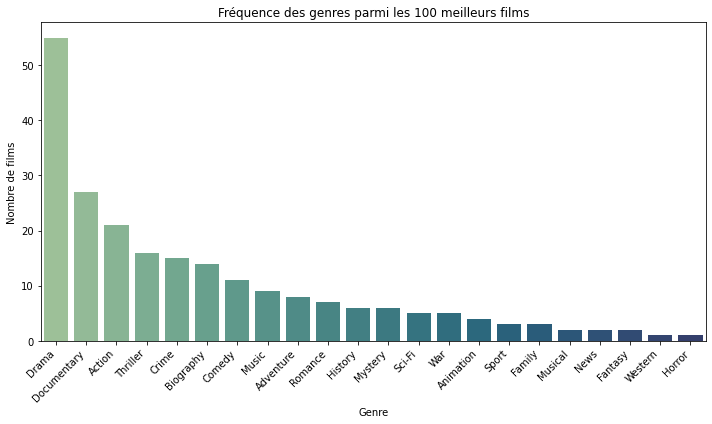

In [34]:
plt.figure(figsize=(10,6))
sns.barplot(data=genre_counts, x='Genre', y='Nombre de films', palette='crest')
plt.xticks(rotation=45, ha='right')
plt.title("Fréquence des genres parmi les 100 meilleurs films")
plt.xlabel("Genre")
plt.ylabel("Nombre de films")
plt.tight_layout()
plt.show()

# Commentaires
#### Les films de genre dramatique occupent une place prédominante dans le classement, avec 55 occurrences, ce qui en fait de loin le genre le plus représenté. Ce constat témoigne d’un fort attrait du public et des critiques pour les récits émotionnellement profonds, qu’ils soient exclusivement dramatiques ou associés à d’autres genres comme Crime ou Biography.

#### En deuxième position, on retrouve les documentaires, avec 27 apparitions, traduisant une appréciation marquée pour les œuvres ancrées dans le réel, souvent porteuses de messages puissants ou révélateurs.

#### Les genres action, thriller et crime suivent avec respectivement 21, 16 et 15 films, soulignant un intérêt soutenu pour les intrigues à suspense, les tensions narratives et les histoires percutantes, souvent inspirées de faits réels ou abordant des enjeux sociaux complexes.

### $$Existe-t-il\; un\; rapport\; entre\; la\; durée\; des\; films\; et\; leur\; niveau\; d'appréciation\; par\; les\; spectateurs?$$

In [35]:
# Faisons une catégorisation des films suivant leur durée
Classes = """SELECT 
  CASE 
    WHEN runtime_minutes < 60 THEN '< 60 min'
    WHEN runtime_minutes BETWEEN 60 AND 90 THEN '60-90 min'
    WHEN runtime_minutes BETWEEN 91 AND 120 THEN '91-120 min'
    WHEN runtime_minutes BETWEEN 121 AND 150 THEN '121-150 min'
    ELSE '> 150 min'
  END AS durée_categorie,
  COUNT(*) AS Nbre_films,
  AVG(averagerating) AS avg_rating,
  AVG(weighted_score) AS avg_score
FROM imbd_cleaned_balanced
WHERE runtime_minutes IS NOT NULL
GROUP BY durée_categorie
ORDER BY avg_score DESC;"""

pd.read_sql(Classes, conn)

,durée_categorie,Nbre_films,avg_rating,avg_score
0,> 150 min,1280,6.664219,6.495650
1,121-150 min,5222,6.419724,6.432344
2,< 60 min,3676,7.151279,6.351665
3,91-120 min,26682,6.245296,6.259280
4,60-90 min,28817,6.250186,6.214455


Il semble exister une corrélation positive entre durée et appréciation, jusqu’à 150 minutes et au-delà.

Les films très courts peuvent être très bien notés (< 60 minutes : 3 676 avis), mais uniquement par un public restreint.

Les films de longueur "standard" sont les plus nombreux mais pas les mieux notés.

### Ces notes défavorables pour les films de longueurs standard ne traduisent pas forcément une mauvaise appréciation de ces films. Cela peut être du au effet du nombre de votes pourvu que ce sont les films de cette catégorie qui sont les plus connus.

### Voyons si le nombre n'influence pas la note effetivement :

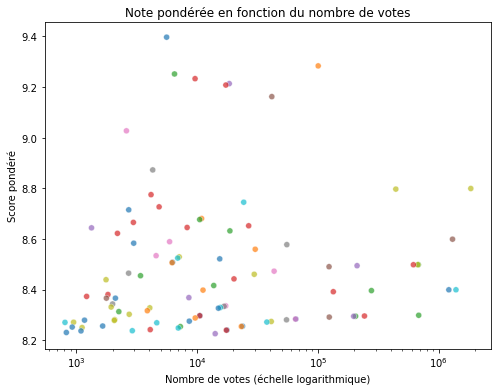

In [36]:
plt.figure(figsize = (8,6))
sns.scatterplot(data = df_top100, x='numvotes', y='weighted_score', hue='genres', palette='tab10', legend=False, alpha=0.7)
plt.xscale('log')
plt.title("Note pondérée en fonction du nombre de votes")
plt.xlabel("Nombre de votes (échelle logarithmique)")
plt.ylabel("Score pondéré")
plt.show()

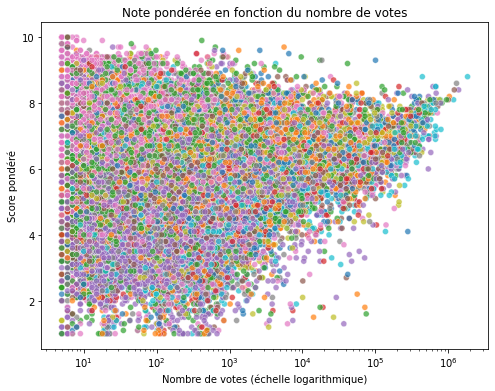

In [37]:
plt.figure(figsize = (8,6))
sns.scatterplot(data = Base_DataFrame, x='numvotes', y='averagerating', hue='genres', palette='tab10', legend=False, alpha=0.7)
plt.xscale('log')
plt.title("Note pondérée en fonction du nombre de votes")
plt.xlabel("Nombre de votes (échelle logarithmique)")
plt.ylabel("Score pondéré")
plt.show()

Il n'existe pas de corrélation linéaire notable entre la durée des films et leur niveau d’appréciation (rating ou score pondéré).

La différence de durée moyenne entre les meilleurs films (133 min) et la moyenne générale (93 min) n'est probablement pas due à une relation linéaire directe.

Donc, un test d’hypothèse sur la différence de moyenne (test de Student) reste pertinent pour vérifier s’il y a un effet réel, non aléatoire.

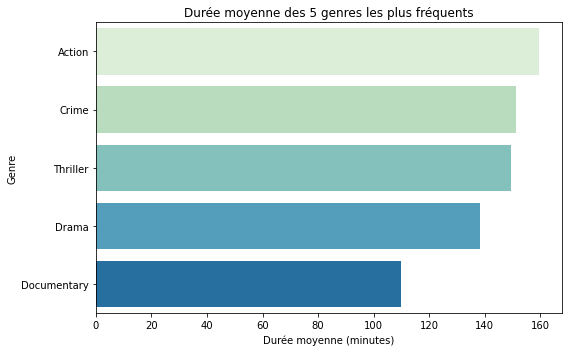

        genres  duree_moyenne  nombre_films
0       Action          159.8            21
1        Crime          151.3            15
4     Thriller          149.4            16
3        Drama          138.3            55
2  Documentary          109.9            27


In [38]:
# Séparation des genres multiples
Durée_genre = df_top100[['genres', 'runtime_minutes']].dropna()
Durée_genre = Durée_genre.assign(genres=Durée_genre['genres'].str.split(',')).explode('genres')

# Trouver les 5 genres les plus fréquents
top5_genres_freq = Durée_genre['genres'].value_counts().head(5).index

# Filtrer les données pour ces 5 genres
top5_genres_data = Durée_genre[Durée_genre['genres'].isin(top5_genres_freq)]

# Calcul de la durée moyenne et nombre de films
duree_moyenne_genres = top5_genres_data.groupby('genres').agg(
    duree_moyenne=('runtime_minutes', 'mean'),
    nombre_films=('runtime_minutes', 'count')
).reset_index()

# Tri pour l'affichage
duree_moyenne_genres = duree_moyenne_genres.sort_values(by='duree_moyenne', ascending=False)

# Affichage du graphique
plt.figure(figsize=(8, 5))
sns.barplot(data=duree_moyenne_genres, x='duree_moyenne', y='genres', palette='GnBu')
plt.title("Durée moyenne des 5 genres les plus fréquents")
plt.xlabel("Durée moyenne (minutes)")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()

# Affichage numérique
print(duree_moyenne_genres.round(1))

##### Il peut exister une corrélation entre la durée des films et leur niveau d'appréciation par le public oui mais cette corrélation ne saute aux yeux pour les 100 meilleurs films.

Les genres qu'on aime les plus apparaissent dans cet ordre : Drama, Documentary et Action.
Le classement de ces trois genres suivant leur durée moyenne (plus long au moins long) est cependant Action, Drama et Documentaire.

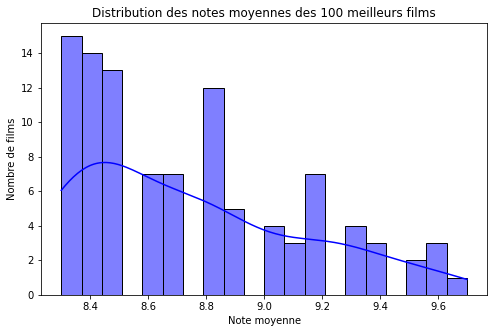

In [39]:
# Visualisons la répartition de la note des 100 meilleurs films
plt.figure(figsize=(8,5))
sns.histplot(df_top100['averagerating'], bins=20, kde=True, color='blue')
plt.title("Distribution des notes moyennes des 100 meilleurs films")
plt.xlabel("Note moyenne")
plt.ylabel("Nombre de films")
plt.show()

In [40]:
# Calculons la durée moyenne des 100 films les mieux notés
x_bar = df_top100['runtime_minutes'].mean()
print(f"La durée moyenne des 100 films les mieux appréciés est de", x_bar, "minutes")

La durée moyenne des 100 films les mieux appréciés est de 133.69 minutes


In [41]:
# Calculons les paramètres statistiques de base de notre jeu de données
Stat_basic = """SELECT 
  COUNT(*) AS total_films,
  AVG(runtime_minutes) AS moyenne_duree,
  AVG(averagerating) AS moyenne_rating,
  AVG(numvotes) AS moyenne_vote,
  AVG(weighted_score) AS moyenne_score
FROM imbd_cleaned_balanced
WHERE runtime_minutes IS NOT NULL AND runtime_minutes <= 300;"""

pd.read_sql(Stat_basic, conn)

,total_films,moyenne_duree,moyenne_rating,moyenne_vote,moyenne_score
0,65677,93.499429,6.320184,3955.838497,6.26315


In [42]:
# Calculons les paramètres de Pearson pour faire ressortir une éventuelle corrélation
query = """
SELECT runtime_minutes, averagerating, weighted_score
FROM imbd_cleaned_balanced
WHERE runtime_minutes IS NOT NULL;
"""

df_test = pd.read_sql(query, conn)

# Corrélation entre durée et appréciation
print("Les paramètres de corrélation durée vs rating :", pearsonr(df_test["runtime_minutes"], df_test["averagerating"]))
print("Les paramètres de corrélation durée vs score pondéré :", pearsonr(df_test["runtime_minutes"], df_test["weighted_score"]))

Les paramètres de corrélation durée vs rating : (-0.043306481792242564, 1.2079222105525807e-28)
Les paramètres de corrélation durée vs score pondéré : (0.08745377492665846, 1.1476519903454536e-111)


Il n'existe pas de corrélation linéaire notable entre la durée des films et leur niveau d’appréciation (rating ou score pondéré).

La différence de durée moyenne entre les meilleurs films (133 min) et la moyenne générale (93 min) n'est probablement pas due à une relation linéaire directe.

Donc, un test d’hypothèse sur la différence de moyenne (test de Student) reste pertinent pour vérifier s’il y a un effet réel, non aléatoire.

##### Testons cette différence entre la durée moyenne des 100 films les mieux notés et la durée moyenne de l'ensemble des films de la base de données.

##### S'agit-il d'une simple différence occasionnée par pur hasard ou existe-t-il vraiment une relation entre la durée d'un film et le niveau d'appréciation des spectateurs?

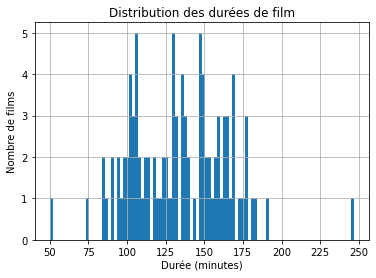

In [43]:
# Faisons d'abord ressortir la répartition de la durée des meilleurs films.
df_top100['runtime_minutes'].hist(bins=100)
plt.title("Distribution des durées de film")
plt.xlabel("Durée (minutes)")
plt.ylabel("Nombre de films")
plt.show()

In [44]:
query = """
SELECT runtime_minutes, averagerating, weighted_score
FROM imbd_cleaned_balanced
WHERE runtime_minutes IS NOT NULL;
"""

df_visualiser = pd.read_sql(query, conn)

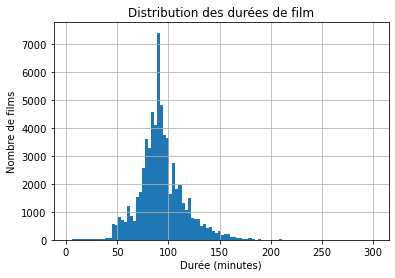

In [45]:
# Et maintenant la répartition de la durée des films.
df_visualiser['runtime_minutes'].hist(bins=100)
plt.title("Distribution des durées de film")
plt.xlabel("Durée (minutes)")
plt.ylabel("Nombre de films")
plt.show()

### Hypothèses

- $Null$ $hypothesis$ $(H₀)$: La durée moyenne des films les mieux notés n'est pas vraiment différente de celle de l'ensemble de tout les films, donc la durée des films n'a pas d'incidence sur leur niveau d'appréciation.   

  $$ H_0: \mu_{\text{best_films}} = \mu_{\text{all_films}} $$
 

- $Alternative$ $hypothesis$ $(H₁)$: La durée des films influence le niveau d'appréciation des spectatteurs.  
  
  $$ H_1: \mu_{\text{best_films}} \ne \mu_{\text{all_films}} $$

In [46]:
print("All:", Base_DataFrame['runtime_minutes'].describe())

All: count    65677.000000
mean        93.499429
std         22.812955
min          3.000000
25%         81.000000
50%         91.000000
75%        104.000000
max        300.000000
Name: runtime_minutes, dtype: float64


In [47]:
print("Top 100:", df_top100['runtime_minutes'].describe())

Top 100: count    100.000000
mean     133.690000
std       31.079791
min       50.000000
25%      106.750000
50%      133.500000
75%      157.250000
max      247.000000
Name: runtime_minutes, dtype: float64


In [48]:
# Test de Student
t_stat, p_value = ttest_ind(df_top100['runtime_minutes'], Base_DataFrame['runtime_minutes'], equal_var=False)

print("Statistique t :", t_stat)
print("P-value :", p_value)

Statistique t : 12.926115114814458
P-value : 5.421163197680333e-23


In [49]:
print(f"Le P-value est largement inférieur à 0.05, (p_value = {p_value}), on peut donc se permettre de rejeter l'hypothèse nulle suivant laquelle il n'y a pas de différence entre la durée moyenne des films les mieux notés et celle de tous les films")

Le P-value est largement inférieur à 0.05, (p_value = 5.421163197680333e-23), on peut donc se permettre de rejeter l'hypothèse nulle suivant laquelle il n'y a pas de différence entre la durée moyenne des films les mieux notés et celle de tous les films


#### Commentaires
On peut rejeter l'hypothèse nulle ($H_0$) d’égalité des moyennes au profit de l’hypothèse alternative ($H_1$).
Cela signifie que les films les mieux notés ont, en moyenne, une durée significativement plus longue que les films de la base dans son ensemble.

Ce résultat laisse supposer que la durée pourrait jouer un rôle (même partiel) dans l’appréciation des films par les spectateurs, bien qu’une corrélation directe entre durée et note ait été jugée très faible.

# Visualisation

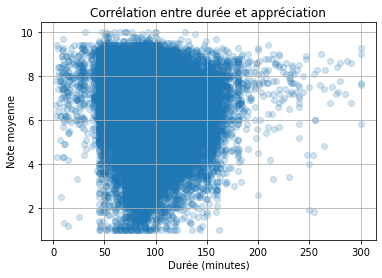

In [50]:
plt.scatter(df_visualiser['runtime_minutes'], df_visualiser['averagerating'], alpha=0.2)
plt.xlabel("Durée (minutes)")
plt.ylabel("Note moyenne")
plt.title("Corrélation entre durée et appréciation")
plt.grid(True)
plt.show()

Le graphique de type Scatter n'exprime pas trop d'information claire sur la relation entre la durée des films et leur note moyenne en raison de leur concentration trop élevée, ce qui conduit à l'apparition d'un nuage dense peu expressif.

###### Essayons un autre modèle.

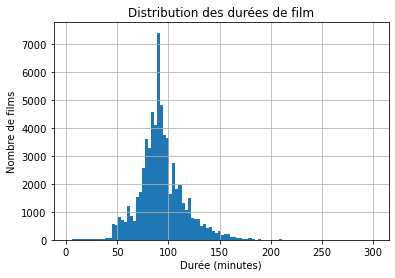

In [51]:
# Faisons d'abord ressortir la répartition de la durée des films.
df_visualiser['runtime_minutes'].hist(bins=100)
plt.title("Distribution des durées de film")
plt.xlabel("Durée (minutes)")
plt.ylabel("Nombre de films")
plt.show()

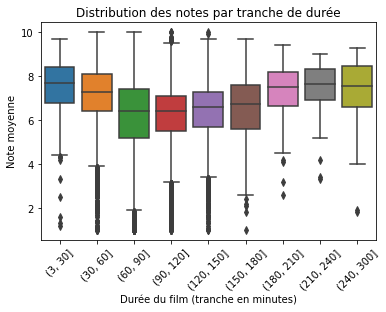

In [52]:
# Créer des tranches de durée
df_visualiser['runtime_bins'] = pd.cut(df_visualiser['runtime_minutes'], bins=[3, 30, 60, 90, 120, 150, 180, 210, 240, 300])

# Tracer un boxplot
sns.boxplot(x='runtime_bins', y='averagerating', data=df_visualiser)
plt.xticks(rotation=45)
plt.xlabel("Durée du film (tranche en minutes)")
plt.ylabel("Note moyenne")
plt.title("Distribution des notes par tranche de durée")
plt.show()

#### Commentaires
Les films très courts (moins de 60 minutes) présentent des notes moyennes globalement élevées, bien que leur dispersion soit importante, avec plusieurs valeurs aberrantes vers le bas.

Entre 60 et 120 minutes, les notes médianes ont tendance à diminuer légèrement. C’est notamment dans l’intervalle [60, 90] minutes que la médiane est la plus basse du graphique, avec une distribution globalement plus étalée.

À partir de 120 minutes, la tendance s’inverse progressivement : les notes médianes augmentent de façon modérée mais régulière, et la variabilité semble légèrement plus contenue.

Les films très longs (plus de 210 minutes) obtiennent à nouveau des notes élevées, avec des médianes comparables à celles des films courts. Cela suggère que les œuvres très longues, souvent ambitieuses, sont bien reçues par le public.

Malgré quelques différences visibles dans les médianes et les distributions, la majorité des tranches présentent des notes situées dans une fourchette assez proche (entre 6 et 8), ce qui confirme une relative stabilité des appréciations quel que soit le format.

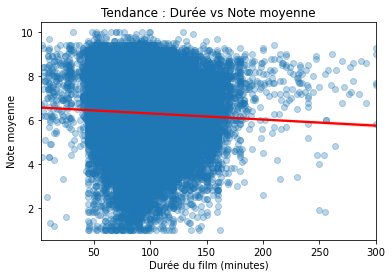

In [53]:
sns.regplot(x='runtime_minutes', y='averagerating', data=df_visualiser, scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.xlabel("Durée du film (minutes)")
plt.ylabel("Note moyenne")
plt.title("Tendance : Durée vs Note moyenne")
plt.show()

#### Commentaire
##### La ligne de regression est de très faible pente négative, cela signifie la corrélation est faible entre la durée et l’évaluation mais qu’en moyenne, plus un film est long, moins il a tendance à être bien noté (aussi peu fiable et globale qu'il soit).

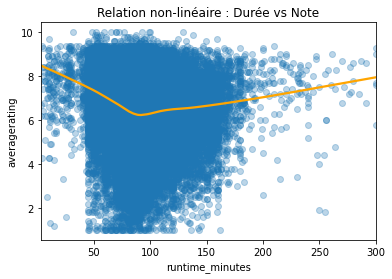

In [54]:
sns.regplot(x='runtime_minutes', y='averagerating', data=df_visualiser, lowess=True, scatter_kws={'alpha':0.3}, line_kws={'color':'orange'})
plt.title("Relation non-linéaire : Durée vs Note")
plt.show()

#### Commentaire
###### Il semble y avoir une relation non linéaire entre la durée d’un film et son appréciation : les films qui s’écartent des formats classiques autour de 90-100 minutes pourraient être mieux reçus par le public.

### EXPORTATION DE DONNEES

In [55]:
Movie_DataFrameBI = pd.read_sql("SELECT * FROM imbd_cleaned_balanced;", conn)
Movie_DataFrameBI.to_csv("Movie_DataBI.csv", index=False)

In [61]:
df_top100.to_csv("df_top100.csv", index=False)

## FERMETURE

In [54]:
conn.close()

## $$ 2 - Le \;fichier\; tsv\; rt.movie\_info $$

In [87]:
df5

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1555,1996,Forget terrorists or hijackers -- there's a ha...,R,Action and Adventure|Horror|Mystery and Suspense,NaN,NaN,"Aug 18, 2006","Jan 2, 2007",$,"33,886,034",106 minutes,New Line Cinema
1556,1997,The popular Saturday Night Live sketch was exp...,PG,Comedy|Science Fiction and Fantasy,Steve Barron,Terry Turner|Tom Davis|Dan Aykroyd|Bonnie Turner,"Jul 23, 1993","Apr 17, 2001",NaN,NaN,88 minutes,Paramount Vantage
1557,1998,"Based on a novel by Richard Powell, when the l...",G,Classics|Comedy|Drama|Musical and Performing Arts,Gordon Douglas,NaN,"Jan 1, 1962","May 11, 2004",NaN,NaN,111 minutes,NaN
1558,1999,The Sandlot is a coming-of-age story about a g...,PG,Comedy|Drama|Kids and Family|Sports and Fitness,David Mickey Evans,David Mickey Evans|Robert Gunter,"Apr 1, 1993","Jan 29, 2002",NaN,NaN,101 minutes,NaN


In [88]:
# Calcul du pourcentage de valeurs manquantes par colonne
valeurs_manquantes = df5.isnull().mean() * 100
valeurs_manquantes = valeurs_manquantes.sort_values(ascending=True)
valeurs_manquantes

id               0.000000
rating           0.192308
genre            0.512821
runtime          1.923077
synopsis         3.974359
director        12.756410
theater_date    23.012821
dvd_date        23.012821
writer          28.782051
studio          68.333333
currency        78.205128
box_office      78.205128
dtype: float64

In [89]:
movie_info = df5.dropna(subset=["box_office","genre"])
movie_info.shape

(340, 12)

In [90]:
movie_info['box_office'].dtype

dtype('O')

In [91]:
# Changement de types de la colonne box_office
movie_info['box_office'] = movie_info['box_office'].str.replace(',','')
movie_info['box_office'] = pd.to_numeric(movie_info['box_office'])

In [96]:
movie_info['mn_runtime'] = movie_info['runtime'].str.extract('(\d+)').astype(float)

In [97]:
best_movie = movie_info.sort_values(by=['box_office'], ascending=[False]).head(100)
best_movie

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio,mn_runtime
827,1071,This depiction of the last 12 hours in the lif...,R,Drama,Mel Gibson,Mel Gibson|Benedict Fitzgerald,"Feb 25, 2004","Aug 31, 2004",$,368000000,127 minutes,Newmarket Film Group,127.0
877,1136,The Hobbit: An Unexpected Journey follows titl...,PG-13,Action and Adventure|Science Fiction and Fantasy,Peter Jackson,Peter Jackson|Philippa Boyens|Guillermo del To...,"Dec 14, 2012","Mar 19, 2013",$,303001229,170 minutes,Warner Bros.,170.0
1188,1525,"In Skyfall, Bond's loyalty to M is tested as h...",PG-13,Action and Adventure|Mystery and Suspense,Sam Mendes,John Logan|Robert Wade|Neal Purvis,"Nov 9, 2012","Mar 11, 2013",$,299300000,145 minutes,MGM,145.0
690,883,"Now that Greg Focker is ""in"" with his soon-to-...",PG-13,Comedy,Jay Roach,Jim Herzfeld|John Hamburg,"Dec 22, 2004","Apr 26, 2005",$,279167575,118 minutes,Universal Pictures,118.0
1117,1442,Youthful wizard Harry Potter returns to the sc...,PG,Kids and Family|Science Fiction and Fantasy,Chris Columbus,Steve Kloves,"Nov 15, 2002","Apr 11, 2003",$,261835892,161 minutes,Warner Bros. Pictures,161.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,10,Some cast and crew from NBC's highly acclaimed...,PG-13,Comedy,Jake Kasdan,Mike White,"Jan 11, 2002","Jun 18, 2002",$,41032915,82 minutes,Paramount Pictures,82.0
1235,1598,Max Payne is a maverick cop - a mythic anti-he...,PG-13,Action and Adventure|Drama|Mystery and Suspense,NaN,Beau Thorne,"Oct 17, 2008","Jan 20, 2009",$,40632110,100 minutes,20th Century Fox,100.0
358,468,Television actor-turned-director Brian Robbins...,PG-13,Comedy|Drama,Brian Robbins,John Gatins,"Sep 14, 2001","Feb 19, 2002",$,39697363,115 minutes,Paramount Pictures,115.0
1383,1785,The director of Mortal Kombat (1995) adapts an...,R,Action and Adventure|Horror|Mystery and Suspense,NaN,NaN,"Mar 15, 2002","Jul 30, 2002",$,39532308,100 minutes,Columbia Tristar Pictures,100.0


In [70]:
# Séparation des genres combinés en une seule liste
Tout_genre = best_movie['genre'].dropna().str.split('|').explode()

# Compter la fréquence d'apparition de chaque genre
genres_counts = Tout_genre.value_counts().reset_index()
genres_counts.columns = ['Genre', 'Nombre de films']

print(genres_counts.to_string(index=False))

                       Genre  Nombre de films
                      Comedy               49
                       Drama               44
        Action and Adventure               37
        Mystery and Suspense               24
                     Romance               18
             Kids and Family               16
 Science Fiction and Fantasy               15
                   Animation               10
                      Horror                7
                 Documentary                2
 Musical and Performing Arts                1


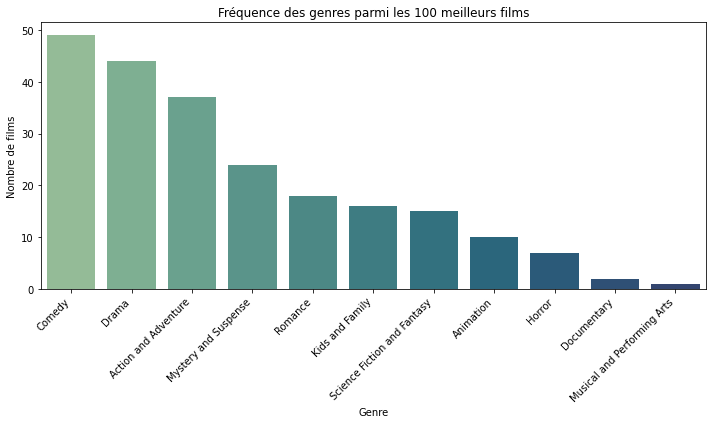

In [93]:
plt.figure(figsize=(10,6))
sns.barplot(data=genres_counts, x='Genre', y='Nombre de films', palette='crest')
plt.xticks(rotation=45, ha='right')
plt.title("Fréquence des genres parmi les 100 meilleurs films")
plt.xlabel("Genre")
plt.ylabel("Nombre de films")
plt.tight_layout()
plt.show()

In [101]:
moy = movie_info['mn_runtime'].mean()
print(f'La durée moyenne des films de façon globale est de', moy)

La durée moyenne des films de façon globale est de 106.69822485207101


In [102]:
moyb = best_movie['mn_runtime'].mean()
print(f'La durée moyenne des 100 meilleurs films est de', moyb)

La durée moyenne des 100 meilleurs films est de 109.34343434343434


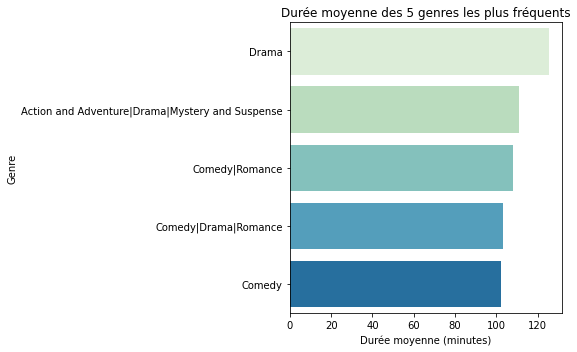

                                             genre  duree_moyenne  \
4                                            Drama          125.3   
0  Action and Adventure|Drama|Mystery and Suspense          110.9   
3                                   Comedy|Romance          108.0   
2                             Comedy|Drama|Romance          103.2   
1                                           Comedy          102.4   

   nombre_films  
4             7  
0             8  
3             5  
2             8  
1            14  


In [104]:
# Séparation des genres multiples
Durée_genre = best_movie[['genre', 'mn_runtime']].dropna()
Durée_genre = Durée_genre.assign(genres=Durée_genre['genre'].str.split('|')).explode('genre')

# Trouver les 5 genres les plus fréquents
top5_genres_freq = Durée_genre['genre'].value_counts().head(5).index

# Filtrer les données pour ces 5 genres
top5_genres_data = Durée_genre[Durée_genre['genre'].isin(top5_genres_freq)]

# Calcul de la durée moyenne et nombre de films
duree_moyenne_genres = top5_genres_data.groupby('genre').agg(
    duree_moyenne=('mn_runtime', 'mean'),
    nombre_films=('mn_runtime', 'count')
).reset_index()

# Tri pour l'affichage
duree_moyenne_genres = duree_moyenne_genres.sort_values(by='duree_moyenne', ascending=False)

# Affichage du graphique
plt.figure(figsize=(8, 5))
sns.barplot(data=duree_moyenne_genres, x='duree_moyenne', y='genre', palette='GnBu')
plt.title("Durée moyenne des 5 genres les plus fréquents")
plt.xlabel("Durée moyenne (minutes)")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()

# Affichage numérique
print(duree_moyenne_genres.round(1))

## $$ 3 - Le \;fichier\; csv\; tmdb.movies $$

In [32]:
df1

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186
...,...,...,...,...,...,...,...,...,...,...
26512,26512,"[27, 18]",488143,en,Laboratory Conditions,0.600,2018-10-13,Laboratory Conditions,0.0,1
26513,26513,"[18, 53]",485975,en,_EXHIBIT_84xxx_,0.600,2018-05-01,_EXHIBIT_84xxx_,0.0,1
26514,26514,"[14, 28, 12]",381231,en,The Last One,0.600,2018-10-01,The Last One,0.0,1
26515,26515,"[10751, 12, 28]",366854,en,Trailer Made,0.600,2018-06-22,Trailer Made,0.0,1


Ce fichier CSV semble être issu d'une base de données dont on ne dispose que d'une partie (notamment avec la présence de la colonne genre_ids qui réfère vraisemblablement à une table genre).

Il serait donc difficile de reconstituer la base dans son intégralité mais on va tenter de tirer le maximum d'information. possible

In [33]:
# Calcul du pourcentage de valeurs manquantes par colonne
valeurs_manquantes = df1.isnull().mean() * 100
valeurs_manquantes = valeurs_manquantes.sort_values(ascending=True)
valeurs_manquantes

Unnamed: 0           0.0
genre_ids            0.0
id                   0.0
original_language    0.0
original_title       0.0
popularity           0.0
release_date         0.0
title                0.0
vote_average         0.0
vote_count           0.0
dtype: float64

Les données de la source tmbd.movies sont complètes

In [35]:
# Supprimons les doublons s'il y en a
df1_unique = df1.drop_duplicates(subset="id", keep="first")
df1_unique

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186
...,...,...,...,...,...,...,...,...,...,...
26512,26512,"[27, 18]",488143,en,Laboratory Conditions,0.600,2018-10-13,Laboratory Conditions,0.0,1
26513,26513,"[18, 53]",485975,en,_EXHIBIT_84xxx_,0.600,2018-05-01,_EXHIBIT_84xxx_,0.0,1
26514,26514,"[14, 28, 12]",381231,en,The Last One,0.600,2018-10-01,The Last One,0.0,1
26515,26515,"[10751, 12, 28]",366854,en,Trailer Made,0.600,2018-06-22,Trailer Made,0.0,1


### Business Recommendation 1

#### Produire ou distribuer majoritairement des films dramatiques, documentaires et d’action, qui sont les plus représentés dans le top 100. Cela reflète une forte demande du public et une probabilité accrue de générer plus d'argent.

### Business Recommendation 2

#### Quoiqu'on n'arrive pas à prouver la linéarité qui existe entre la durée des films et leur appréciation par les spectateurs, je recommande fortement la production de films d’une durée comprise entre 180 et 240 minutes, car ce sont ceux qui présentent les médianes de notes les plus élevées dans le boxplot.

### Business Recommendation 3

#### Investir dans la production ou la promotion de films inspirés de faits réels, de figures historiques ou abordant des enjeux de société (justice, inégalités, droits humains) peut s’avérer particulièrement porteur, tant pour séduire la critique que pour toucher un public sensible à la dimension informative ou émotionnelle de ce type de contenu.

## Conclusion

### Next Steps